### This notebook compares Turn Point Runs using 1000, 2000 and 3000 particles

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cmocean as cm
import glob
import os
import xarray as xr
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sys import platform

%matplotlib inline

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/MIDOSS/results/nbr_partic_test/'
    out_dir = '/Users/rmueller/Documents/Presentations/Graphics/MIDOSS/SOILED/nbr_partic/'
else:
    display('Update file paths for oceans machine')

In [2]:
# define number of particles and the compute time for each run
nbr_partic = [1000,2000,3000,3000]
compute_time = [102, 104, 102]
cpu_time = [5934.55, 6025.39, 5670.18]

In [6]:
tp_akns={} # this is the way to define a new dictionary
thick2D={} # one dictionary is never enough
thick2D_t={} # every house ought to have at least three!
for nparticles in nbr_partic:
    tp_akns[nparticles]  = xr.open_dataset(f'{results_dir}Lagrangian_AKNS_crude_TP_01aug17-08aug17_akns{nparticles}.nc')
    thick2D[nparticles]  = tp_akns[nparticles].Thickness_2D
    thick2D_t[nparticles] = thick2D[nparticles].sum(dim='time')

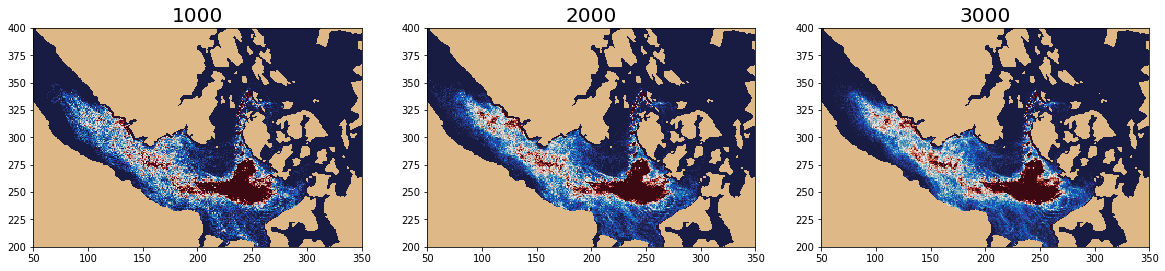

In [11]:
fs = 20
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
# convert xarray into numpy using ".values" in order to gain access to different visualization tools
mappable = ax1.pcolormesh(thick2D_t[1000].values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax2.pcolormesh(thick2D_t[2000].values, vmin = 0, vmax = 40, cmap = cm.cm.balance)
mappable = ax3.pcolormesh(thick2D_t[3000].values, vmin = 0, vmax = 40, cmap = cm.cm.balance)

# add land mask to ax1 and ax2
viz_tools.plot_land_mask(ax1,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(ax2,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
viz_tools.plot_land_mask(ax3,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')

ax1.set_title('1000', fontsize = fs)
ax2.set_title('2000', fontsize = fs)
ax3.set_title('3000', fontsize = fs)

ax1.set_ylim(200,400)
ax2.set_ylim(200,400)
ax3.set_ylim(200,400)

ax1.set_xlim(50,350)
ax2.set_xlim(50,350)
ax3.set_xlim(50,350)

ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)
ax3.set_aspect(aspect=1)

### Check to make sure that the mass of oil in these three cases is the same

In [13]:
#### Load header information

with open(f'{results_dir}resOilOutput_1000.sro', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    header = all_data[4]  
    
# Order header into list array by splitting up string
header_arr = []
header_arr = header.split(' ')

# Remove emtpy entries from list
header_arr = np.asarray([x for x in header_arr if x != ''])

# load mass balance area values
mass_bal = {}
mass_bal_infile = {}

for nparticles in nbr_partic:
    mass_bal_infile[nparticles] = f'{results_dir}resOilOutput_{nparticles}.sro'
    mass_bal[nparticles]        = np.genfromtxt(mass_bal_infile[nparticles], skip_header=6, skip_footer=4)


In [14]:
header_arr

array(['Seconds', 'YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'MassOil',
       'VolOilBeached', 'VolumeBeached', 'VolumeOil', 'Volume', 'Area',
       'TeoricalArea', 'Thickness', 'MEvaporated', 'VEvaporated',
       'FMEvaporated', 'MDispersed', 'VDispersed', 'FMDispersed',
       'MSedimented', 'VSedimented', 'FMSedimented', 'MDissolved',
       'VDissolved', 'FMDissolved', 'MChemDisp', 'VChemDisp', 'FMChemDisp',
       'MOilRecovered', 'VOilRecovered', 'FMOilRecovered', 'MWaterContent',
       'VWaterContent', 'Density', 'Viscosity', 'MBio', 'VBio', 'FMBio',
       'CharacteristicDiameter', 'P_Star', 'AnalyteMass1', 'AnalyteMass2',
       'AnalyteMass3', 'AnalyteMass4', 'AnalyteMass5', 'AnalyteBio1',
       'AnalyteBio2', 'AnalyteBio3', 'AnalyteBio4', 'AnalyteBio5'],
      dtype='<U22')

In [8]:
#number of time points and parameters
[nt,np] = mass_bal[1000].shape

In [6]:
# indices for mass balance (etc)
i_mevaporated = 15
i_mdispersed  = 18
i_mdissolved  = 24
i_mbio        = 37
i_voloilbeached = 8
i_volumebeached = 9
i_volumeoil     = 10
i_volume        = 11
i_vwatercontent = 34
i_msedimented   = 21
i_mwatercontent = 33
i_density   = 35
i_viscosity = 36 
i_area = 12
i_theorical_area = 13
# analyte mass (I thought this was dissolved but the numbers are more reflective of dispersed)
i_analytemass0 = 42
i_analytemass1 = 43
i_analytemass2 = 44
i_analytemass3 = 45
i_analytemass4 = 46
# biodegredation
i_bio0 = 47
i_bio1 = 48
i_bio2 = 49
i_bio3 = 50
i_bio4 = 51

Text(0.5,1,'NBR_PARTIC comparison')

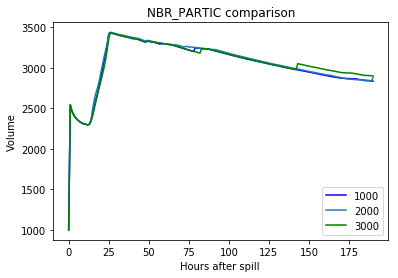

In [21]:
# plot up volume 
plt.plot(mass_bal[1000][range(nt),i_volume],'b')
plt.plot(mass_bal[2000][range(nt),i_volume])
plt.plot(mass_bal[3000][range(nt),i_volume],'g')
plt.ylabel(header_arr[plot_data])
plt.xlabel('Hours after spill ')
plt.legend(['1000', '2000', '3000'])
plt.title('NBR_PARTIC comparison')

Text(0.5,0,'Time after oil release (hours) ')

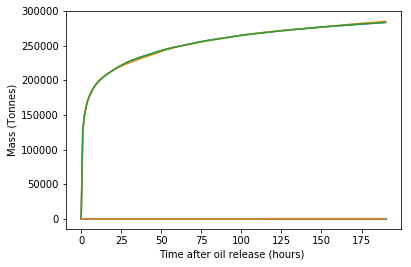

In [35]:
plot_mass = [i_mevaporated, i_mdispersed, i_mdissolved, i_mbio]
for imass in plot_mass: 
    for nparticles in nbr_partic:
        plt.plot(mass_bal[nparticles][range(nt),imass])
plt.ylabel('Mass (Tonnes)')
plt.xlabel('Time after oil release (hours) ')

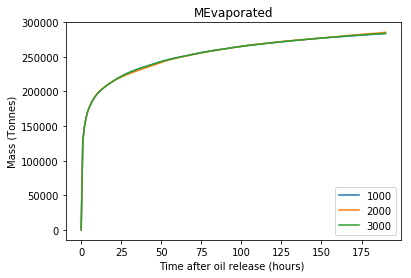

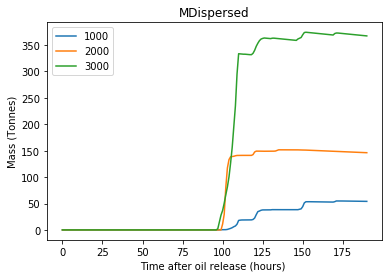

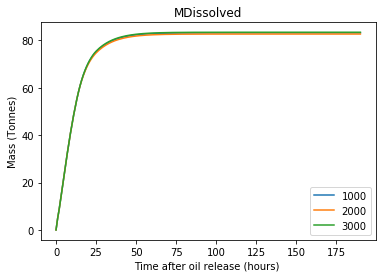

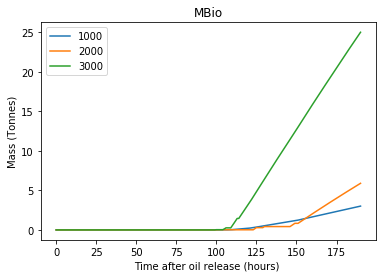

In [41]:
plot_mass = [i_mevaporated, i_mdispersed, i_mdissolved, i_mbio]
for imass in plot_mass: 
    plt.figure()
    for nparticles in nbr_partic:  
        plt.plot(mass_bal[nparticles][range(nt),imass])
    plt.legend(['1000','2000','3000'])        
    plt.ylabel('Mass (Tonnes)')
    plt.xlabel('Time after oil release (hours) ')
    plt.title(header_arr[imass])

### Evaluate results from changing Mass used in MDispersedDT calculation from Me%Var%MassOil to Me%Var%MassINI

In [4]:
nbr_partic = [1000,2000, 3000, 3001]

#### Load header information
with open(f'{results_dir}resOilOutput_1000.sro', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    header = all_data[4]  
    
# Order header into list array by splitting up string
header_arr = []
header_arr = header.split(' ')

# Remove emtpy entries from list
header_arr = np.asarray([x for x in header_arr if x != ''])

# load mass balance area values
mass_bal = {}
mass_bal_infile = {}

for nparticles in nbr_partic:
    if nparticles==3001:
        mass_bal_infile[nparticles] = f'{results_dir}resOilOutput_3000_fix1.sro'
    else:
        mass_bal_infile[nparticles] = f'{results_dir}resOilOutput_{nparticles}.sro'
    mass_bal[nparticles]        = np.genfromtxt(mass_bal_infile[nparticles], skip_header=6, skip_footer=4)



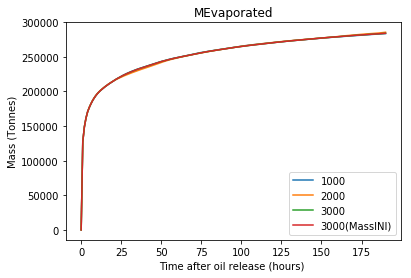

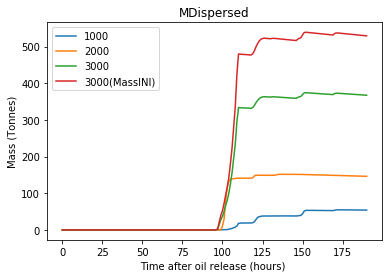

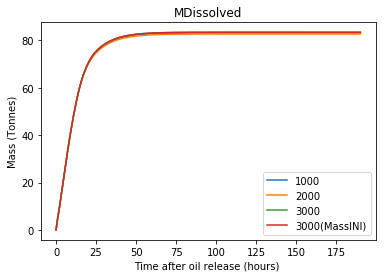

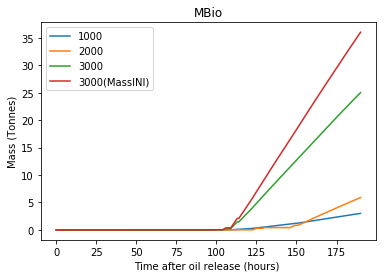

In [12]:
plot_mass = [i_mevaporated, i_mdispersed, i_mdissolved, i_mbio]
for imass in plot_mass: 
    plt.figure()
    for nparticles in nbr_partic:  
        plt.plot(mass_bal[nparticles][range(nt),imass])
    plt.legend(['1000','2000','3000','3000(MassINI)'])        
    plt.ylabel('Mass (Tonnes)')
    plt.xlabel('Time after oil release (hours) ')
    plt.title(header_arr[imass])